In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [17]:
EMPRESA = 'WEGE3.SA'

In [18]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].shift(-1)
    return data_hist

In [19]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA)
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [20]:
def trein_model(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

In [21]:
def predict_tomorrow():
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]])) 


In [22]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

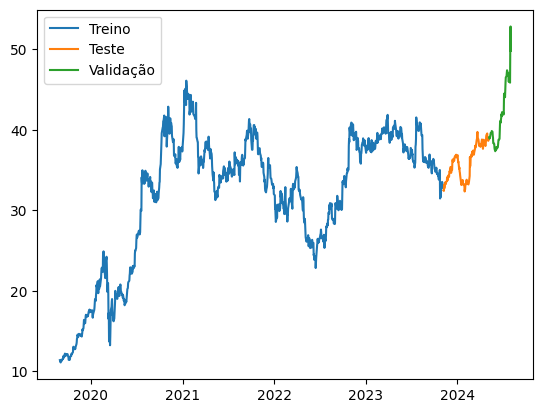

In [23]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## Treinamento da LSTM

## Resultado com dados nunca vistos pelo modelo

In [24]:
model = trein_model(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow()

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1040.8274 - mean_absolute_error: 31.1779 - val_loss: 1103.4026 - val_mean_absolute_error: 33.1442
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 775.5712 - mean_absolute_error: 26.2893 - val_loss: 337.3810 - val_mean_absolute_error: 18.2323
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 151.0958 - mean_absolute_error: 10.6906 - val_loss: 7.6724 - val_mean_absolute_error: 2.2835
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 54.9927 - mean_absolute_error: 5.7486 - val_loss: 12.8238 - val_mean_absolute_error: 3.1287
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.1713 - mean_absolute_error: 2.5112 - val_loss: 0.6646 - val_mean_absolute_error: 0.6079
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0730 - mean_absolute_error: 1.0865 - val_loss: 0.6479 - val_mean_absolute_error: 0.6394
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6928 - mean_absolute_err

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step   


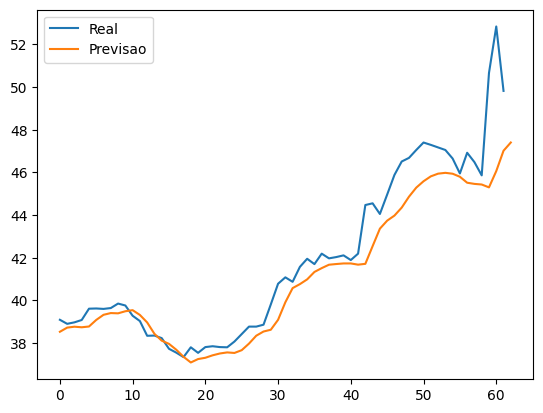

In [25]:
y_pred = model.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

In [26]:
y_tomorrow = predict_tomorrow()
y_pred = [*y_pred, *y_tomorrow[-1]]

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
